In [1]:
from pathlib import Path
from thor_scsi.factory import accelerator_from_config
from thor_scsi.pyflame import Config
import thor_scsi.lib as tslib

import numpy as np
import matplotlib.pyplot as plt

import gtpsa
import os
import time
import copy
import copy
import random


from multiprocessing import Process, Queue, Array
from queue import Empty

from scipy.stats import truncnorm, norm


prefix = Path(os.environ["HOME"])
prefix = Path("/home/al3xber")
t_dir =  prefix / "Desktop" / "Workspace"
t_file = t_dir / "BII_NLKmode_3d_start.lat"   #file is provided

x_, px_ = 0, 1
y_, py_ = 2, 3

emittance_start = 70e-9
nv = 6
mo = 1
default_desc = gtpsa.desc(nv, mo)


def create_nlk_interpolation(nlk_name):
    def compute_mirror_position_plate(ref_pos, mirror_pos, *, y_plane=True):
        assert y_plane
        dy = ref_pos.imag - mirror_pos.imag
        return ref_pos - 2 * dy * 1j

    # fmt: off
    ref_pos1 =  8e-3 +  7e-3j
    ref_pos2 = 17e-3 + 15e-3j
    # fmt: on
    t_current = -7e2

    # fmt: off
    t_current *= 1 - 1 * 0.14 / 2
    ref_pos1  *= 1 - 0.14
    ref_pos2  *= 1 - 0.14

    plate_position1 = 5e-3j
    mirror_pos1 = compute_mirror_position_plate(ref_pos1, plate_position1)

    inner = tslib.aircoil_filament(ref_pos1.real, ref_pos1.imag,  t_current)
    outer = tslib.aircoil_filament(ref_pos2.real, ref_pos2.imag, -t_current)
    mirror = tslib.aircoil_filament(mirror_pos1.real, mirror_pos1.imag, -t_current * 0.14)
    nlkf_intp = tslib.NonLinearKickerInterpolation([inner, outer, mirror])

    c = Config()
    c.setAny("L", 0e0)
    c.setAny("name", nlk_name)
    c.setAny("N", 1)
    nlk = tslib.FieldKick(c)
    nlk.set_field_interpolator(nlkf_intp)
    return nlk, nlkf_intp


def create_state_space_vector(*, mu_x=0e0, mu_px=0e0, mu_y=0e0, mu_py=0e0, desc=default_desc):
    #ps = gtpsa.ss_vect_double(desc, mo, nv)
    ps = gtpsa.ss_vect_double(0.0)
    #ps.set_identity()
    ps.set_zero()
    ps.x+=mu_x
    ps.px+=mu_px
    ps.y+=mu_y
    ps.py+=mu_py
    ps.copy()
    return ps


acc = accelerator_from_config(t_file)
calc_config = tslib.ConfigType()

#Description of NLK
nlkfk = acc.find("KDNL1KR", 0)
nlk_name = nlkfk.name
_, nlkf_intp = create_nlk_interpolation(nlk_name)

nlkfk.set_field_interpolator(nlkf_intp)

<thor_scsi::core::CellVoid const* @ 0x5579eae20cc0>(cell 201: NonLinearKicker(KDNL1KR) aperture=None observer=None)


In [2]:
def create_nlk_interpolation(nlk_name):
    def compute_mirror_position_plate(ref_pos, mirror_pos, *, y_plane=True):
        assert y_plane
        dy = ref_pos.imag - mirror_pos.imag
        return ref_pos - 2 * dy * 1j

    # fmt: off
    ref_pos1 =  8e-3 +  7e-3j
    ref_pos2 = 17e-3 + 15e-3j
    # fmt: on
    t_current = -7e2

    # fmt: off
    t_current *= 1 - 1 * 0.14 / 2
    ref_pos1  *= 1 - 0.14
    ref_pos2  *= 1 - 0.14

    plate_position1 = 5e-3j
    mirror_pos1 = compute_mirror_position_plate(ref_pos1, plate_position1)

    inner = tslib.aircoil_filament(ref_pos1.real, ref_pos1.imag,  t_current)
    outer = tslib.aircoil_filament(ref_pos2.real, ref_pos2.imag, -t_current)
    mirror = tslib.aircoil_filament(mirror_pos1.real, mirror_pos1.imag, -t_current * 0.14)
    nlkf_intp = tslib.NonLinearKickerInterpolation([inner, outer, mirror])

    c = Config()
    c.setAny("L", 0e0)
    c.setAny("name", nlk_name)
    c.setAny("N", 1)
    nlk = tslib.FieldKick(c)
    nlk.set_field_interpolator(nlkf_intp)
    return nlk, nlkf_intp


In [23]:
x_list = []
px_list = []
for x in np.linspace(-30e-3,30e-3,400):
    ps.set_zero()
    ps.x+=x
    
    nlk.propagate(calc_config,ps)
    x_list.append(ps.x)
    px_list.append(ps.px)

<function matplotlib.pyplot.show(close=None, block=None)>

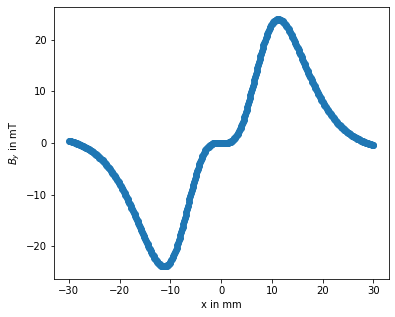

In [29]:
plt.figure(figsize=(6,5))
plt.scatter(np.array(x_list)*1000,np.array(px_list)*1000)
plt.xlabel("x in mm")
plt.ylabel("$B_y$ in mT")
plt.show